#  COVID-19 X-Ray Images EDA + Models

## Tasks to complete
1. Exploratory Data Analysis
2. Image augumentation
3. Base CNN model accuracy calculation
4. Base CNN model with lower imbalance data
5. RESNET 50 model accuracy calculation
6. Xception accuracy calculation
7. AUC Score comparision
8. Final result


## Importing libraries

In [75]:
import numpy as np      # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.metrics import *


ACCURACY_LIST = []
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.layers import GlobalMaxPooling2D
from keras.models import Model

from keras import backend as K

# Get reproducible results
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import os

## Reading the csv files

In [31]:
metadata = pd.read_csv('Chest_xray_Corona_Metadata.csv')
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')

metadata.sample(10)   # reads randomly 10 data samples

train_data = metadata[metadata['Dataset_type'] == 'TRAIN'] # Extracting all the 'Train' data
test_data = metadata[metadata['Dataset_type'] == 'TEST']   # Extarcting all the 'Test' data

print(f"Shape of train data : {train_data.shape}")  # training data 5286 rows
print(f"Shape of test data : {test_data.shape}")    # testing data 624 rows
test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


Unnamed: 0             X_ray_image_name     Label Dataset_type  \
5675        5698  person112_bacteria_539.jpeg  Pnemonia         TEST   
5807        5830      person49_virus_101.jpeg  Pnemonia         TEST   
5455        5478    NORMAL2-IM-0195-0001.jpeg    Normal         TEST   
5609        5632  person134_bacteria_644.jpeg  Pnemonia         TEST   
5798        5821      person57_virus_113.jpeg  Pnemonia         TEST   
5597        5620  person139_bacteria_661.jpeg  Pnemonia         TEST   
5895        5918   person1650_virus_2854.jpeg  Pnemonia         TEST   
5671        5694  person113_bacteria_543.jpeg  Pnemonia         TEST   
5590        5613  person140_bacteria_668.jpeg  Pnemonia         TEST   
5869        5892   person1678_virus_2895.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  
5675                    NaN               bacteria  
5807                    NaN                  Virus  
5455                    NaN                    NaN  
5609                    NaN               bacteria  
5798                    NaN                  Virus  
5597                    NaN               bacteria  
5895                    NaN                  Virus  
5671                    NaN               bacteria  
5590                    NaN               bacteria  
5869                    NaN                  Virus

## Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [32]:
# Null value calculation
print(f"Count of null values in train :\n{train_data.isnull().sum()}")
print(f"Count of null values in test :\n{test_data.isnull().sum()}")

Count of null values in train :
Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5217
Label_1_Virus_category    1342
dtype: int64
Count of null values in test :
Unnamed: 0                  0
X_ray_image_name            0
Label                       0
Dataset_type                0
Label_2_Virus_category    624
Label_1_Virus_category    234
dtype: int64


In [33]:
# Substitute null values with string unknown
train_fill = train_data.fillna('unknown')  # train_fill contains new train data with null replace to 'unknown'
test_fill = test_data.fillna('unknown')    # test_fill contains new test data with null replace to 'unknown'
train_fill.sample(10)  # displaying the train_fill data

Unnamed: 0               X_ray_image_name     Label Dataset_type  \
4724        4724      person605_virus_1169.jpeg  Pnemonia        TRAIN   
991          991      NORMAL2-IM-0978-0001.jpeg    Normal        TRAIN   
1601        1601  person1040_bacteria_2974.jpeg  Pnemonia        TRAIN   
428          428              IM-0606-0001.jpeg    Normal        TRAIN   
2080        2080  person1271_bacteria_3231.jpeg  Pnemonia        TRAIN   
4768        4768   person870_bacteria_2792.jpeg  Pnemonia        TRAIN   
4352        4352   person549_bacteria_2305.jpeg  Pnemonia        TRAIN   
2690        2690  person1720_bacteria_4545.jpeg  Pnemonia        TRAIN   
2914        2914   person265_bacteria_1236.jpeg  Pnemonia        TRAIN   
3971        3971   person502_bacteria_2122.jpeg  Pnemonia        TRAIN   

     Label_2_Virus_category Label_1_Virus_category  
4724                unknown                  Virus  
991                 unknown                unknown  
1601                unknown               bacteria  
428                 unknown                unknown  
2080                unknown               bacteria  
4768                unknown               bacteria  
4352                unknown               bacteria  
2690                unknown               bacteria  
2914                unknown               bacteria  
3971                unknown               bacteria

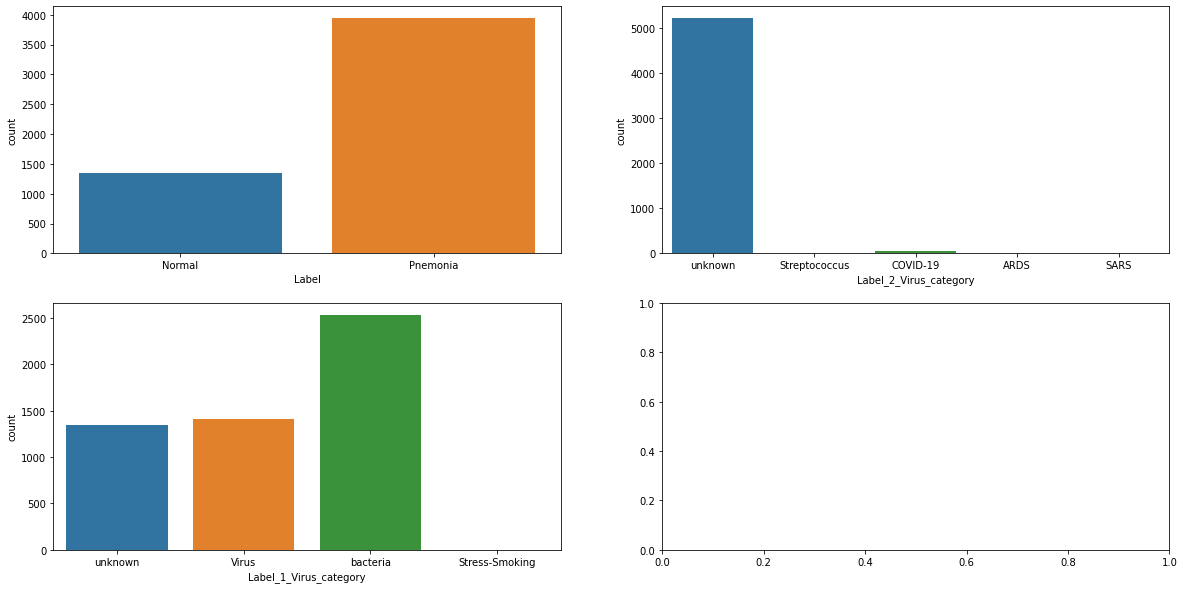

In [34]:
# Count plot for 3 attributes with the addition of "unknown"
targets = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_fill, ax=ax[0, 0]) # this targets the feature 'label'
sns.countplot(x=targets[1], data=train_fill, ax=ax[0, 1]) # this targets the feature 'Label_2_Virus_category'
sns.countplot(x=targets[2], data=train_fill, ax=ax[1, 0]) # this targets the feature 'Label_1_Virus_category'
plt.show()

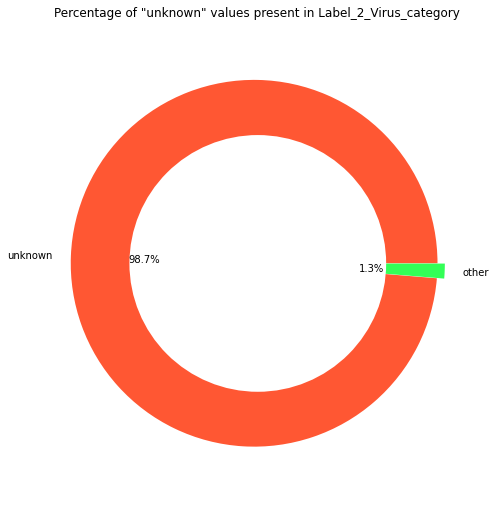

In [35]:
# Pie chart representation of Label_2_Virus_category values

colors = ['#ff5733', '#33ff57']   # colors for the representation used
explode = [0.02, 0.02]            # Giving the shape for the pie chart

values = ['unknown', 'other']

# getting the percentage of "unknown" and not unknown values from the 'Label_2_Virus_category' feature from the data
percentages = [100 * (train_fill[train_fill[targets[1]] == 'unknown'].shape[0]) / train_fill.shape[0],
              100 * (train_fill[train_fill[targets[1]] != 'unknown'].shape[0]) / train_fill.shape[0]]

fig1, ax1 = plt.subplots(figsize=(7, 7))   # setting the chart size

# plotting the pie chart
plt.pie(percentages, colors=colors, labels=values,
        autopct='%1.1f%%', startangle=0, explode=explode)

fig = plt.gcf()
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()
plt.title('Percentage of "unknown" values present in Label_2_Virus_category')
plt.show()

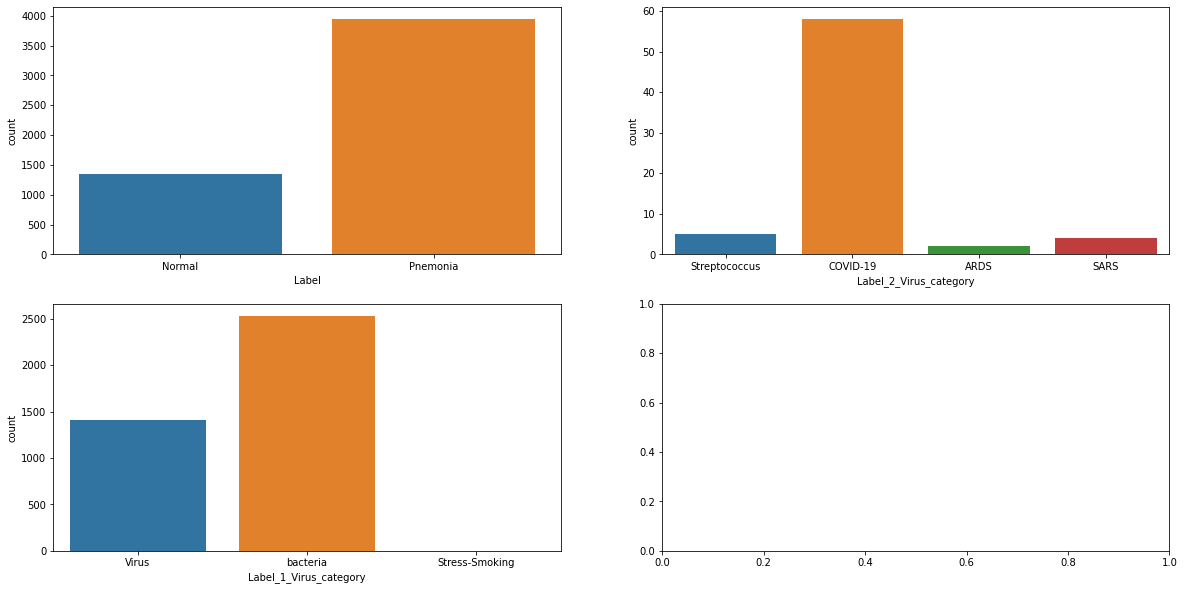

In [12]:
# Count plot for 3 target variables without the "unknown" used instead of the NaN value present(so NaN value are present)
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_data, ax=ax[0, 0]) # this targets the feature 'label'
sns.countplot(x=targets[1], data=train_data, ax=ax[0, 1]) # this targets the feature 'Label_2_Virus_category'
sns.countplot(x=targets[2], data=train_data, ax=ax[1, 0]) # this targets the feature 'Label_1_Virus_category'
plt.show()

In [36]:
# Displaying the results.

print(f"Label = Normal Cases : {train_data[train_data['Label'] == 'Normal'].shape[0]}") # normal cases

print(f"""Label = Pnemonia + Label_2_Virus_category = COVID-19 cases : {train_data[(train_data['Label'] == 'Pnemonia')
      & (train_data['Label_2_Virus_category'] == 'COVID-19')].shape[0]}""")     # Pnemonia and COVID-19 cases

print(f"""Label = Normal + Label_2_Virus_category = COVID-19 cases : {train_data[(train_data['Label'] == 'Normal')
      & (train_data['Label_2_Virus_category'] == 'COVID-19')].shape[0]}""")     # Normal and COVID-19 cases

Label = Normal Cases : 1342
Label = Pnemonia + Label_2_Virus_category = COVID-19 cases : 58
Label = Normal + Label_2_Virus_category = COVID-19 cases : 0


### Inference from count plots and Pie chart
- All COVID-19 patients are classified with attribute Label as Pnemonia. None of them is classified as normal.
- In target "Label_2_Virus_category", "unknown" value is associated with majority of images
- Unknown values consist of 98.7 % of total cases while COVID-19 value consist of less than 1.3 % of total cases.
- Even if we train a model to classify Label_2_virus_category with 98.7 % accuracy, it will be highly inefficient in detecting true positive COVID-19 cases.
- Thus we are going to construct a model which differentiates between (Normal) and (Pnemonia + COVID-19) Cases

## Analysis of Image files

In [37]:
# setting the path of the test and the train dataset folders from my local pc in root folder
TEST_FOLDER = 'dataset/test'
TRAIN_FOLDER = 'dataset/train'

In [45]:
# Taking sample train images from the folder location specified
sample_train_images = list(os.walk(TRAIN_FOLDER))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_train_images))

In [46]:
# Taking sample test images from the folder location specified
sample_test_images = list(os.walk(TEST_FOLDER))[0][2][:8]
sample_test_images = list(map(lambda x: os.path.join(TEST_FOLDER, x), sample_test_images))  # Taking sample test images

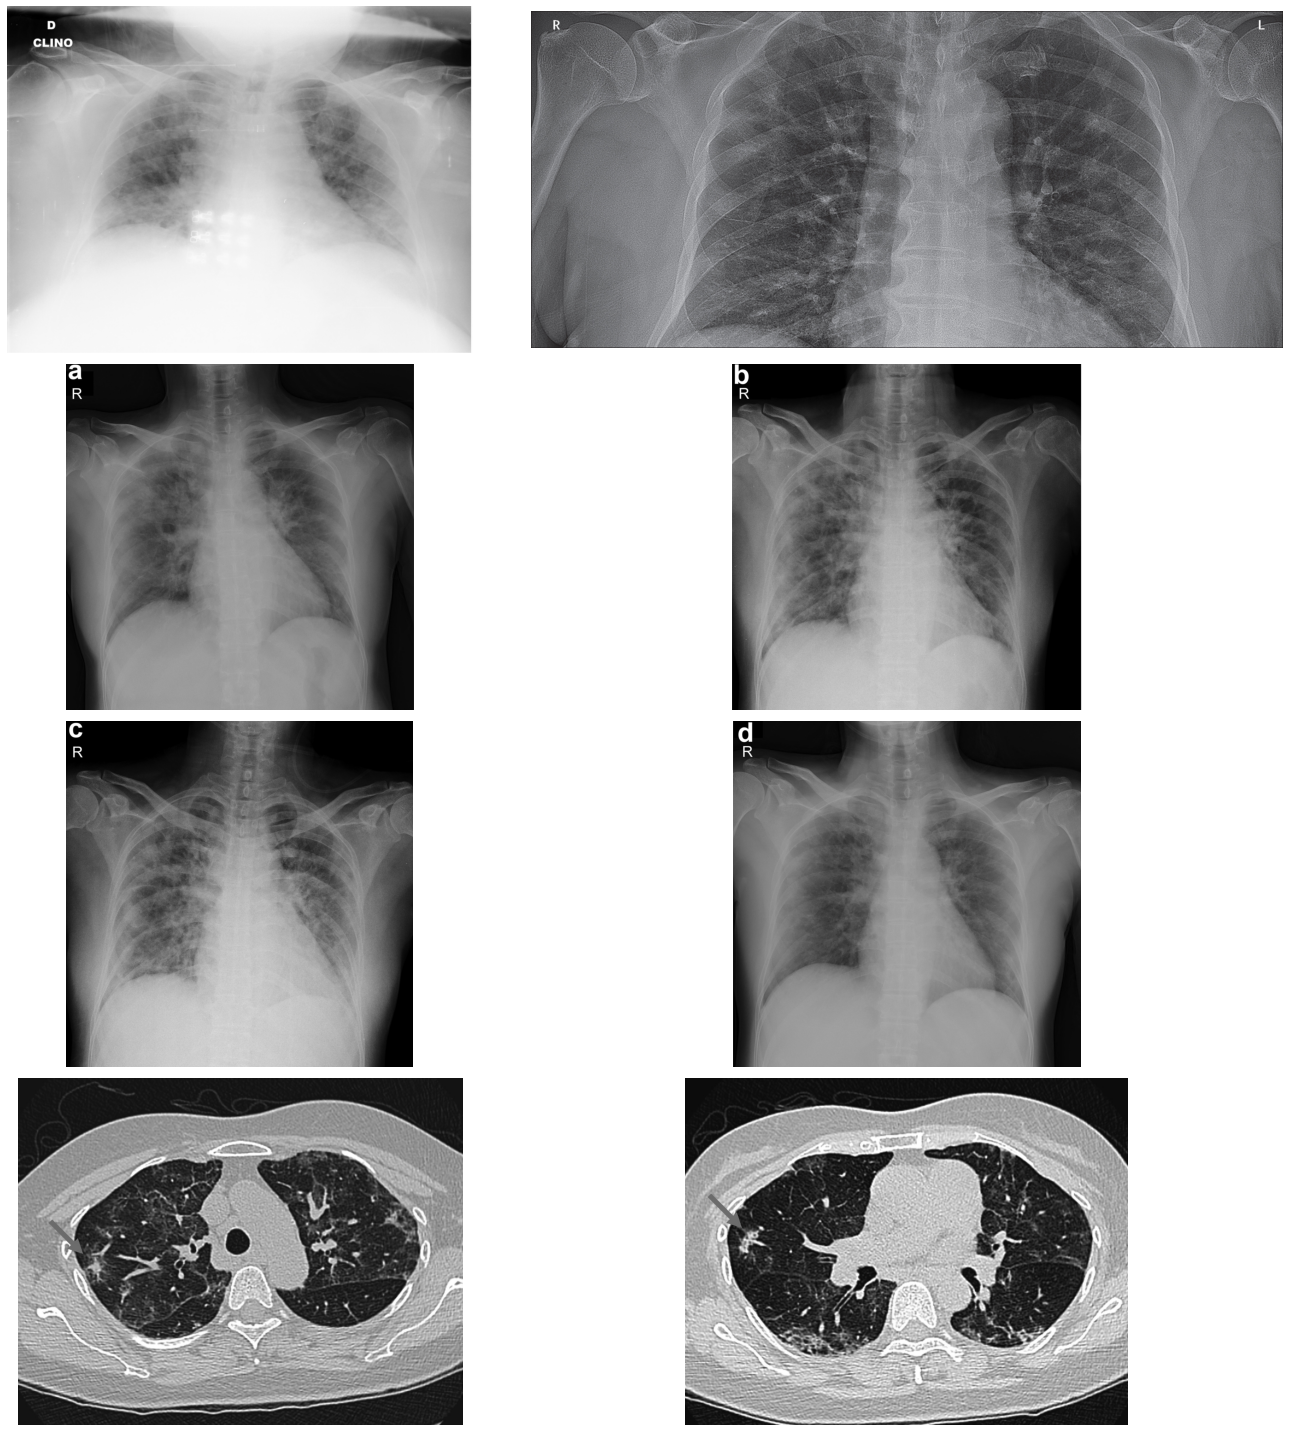

In [47]:
# Plotting the sample training data (train images)
plt.figure(figsize=(20, 20))

for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4, 2, iterator+1)
    plt.axis('off')
    plt.imshow(image)


plt.tight_layout()

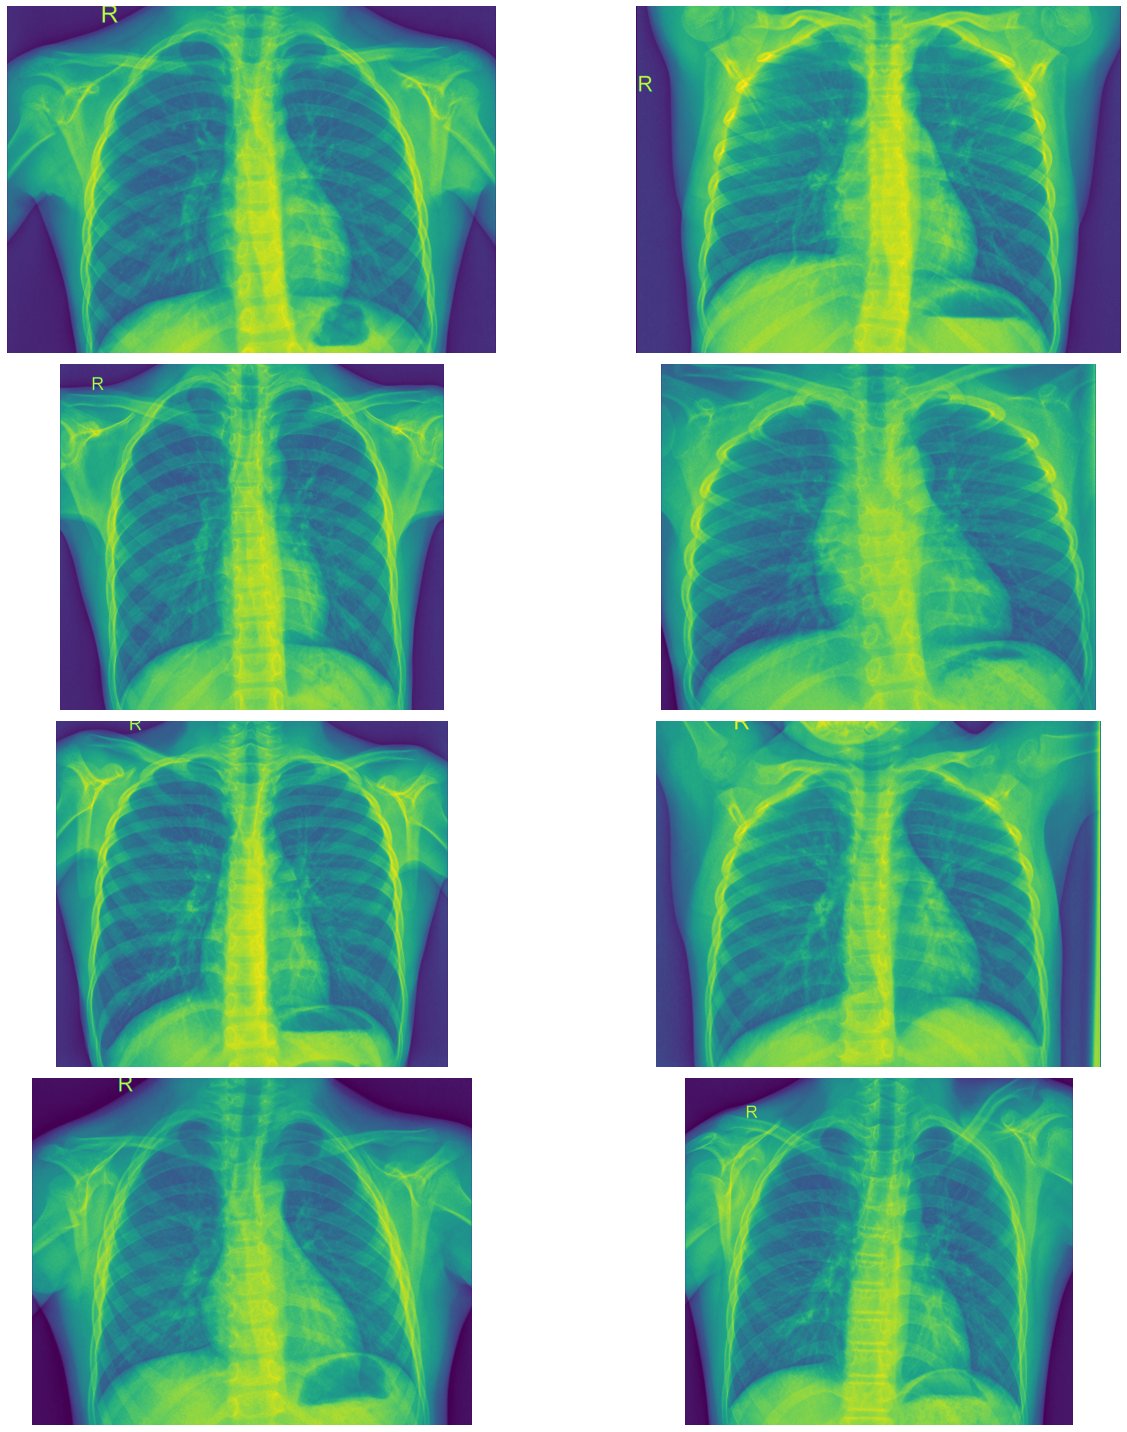

In [48]:
# Plotting the sample test data (test images)
plt.figure(figsize=(20, 20))

for iterator, filename in enumerate(sample_test_images):
    image = Image.open(filename)
    plt.subplot(4, 2, iterator+1)
    plt.axis('off')
    plt.imshow(image)


plt.tight_layout()


### Image Histograms
An image histogram is a type of histogram that acts as a graphical representation of the tonal distribution in a digital image. It plots the number of pixels for each tonal value. By looking at the histogram for a specific image a viewer will be able to judge the entire tonal distribution at a glance.

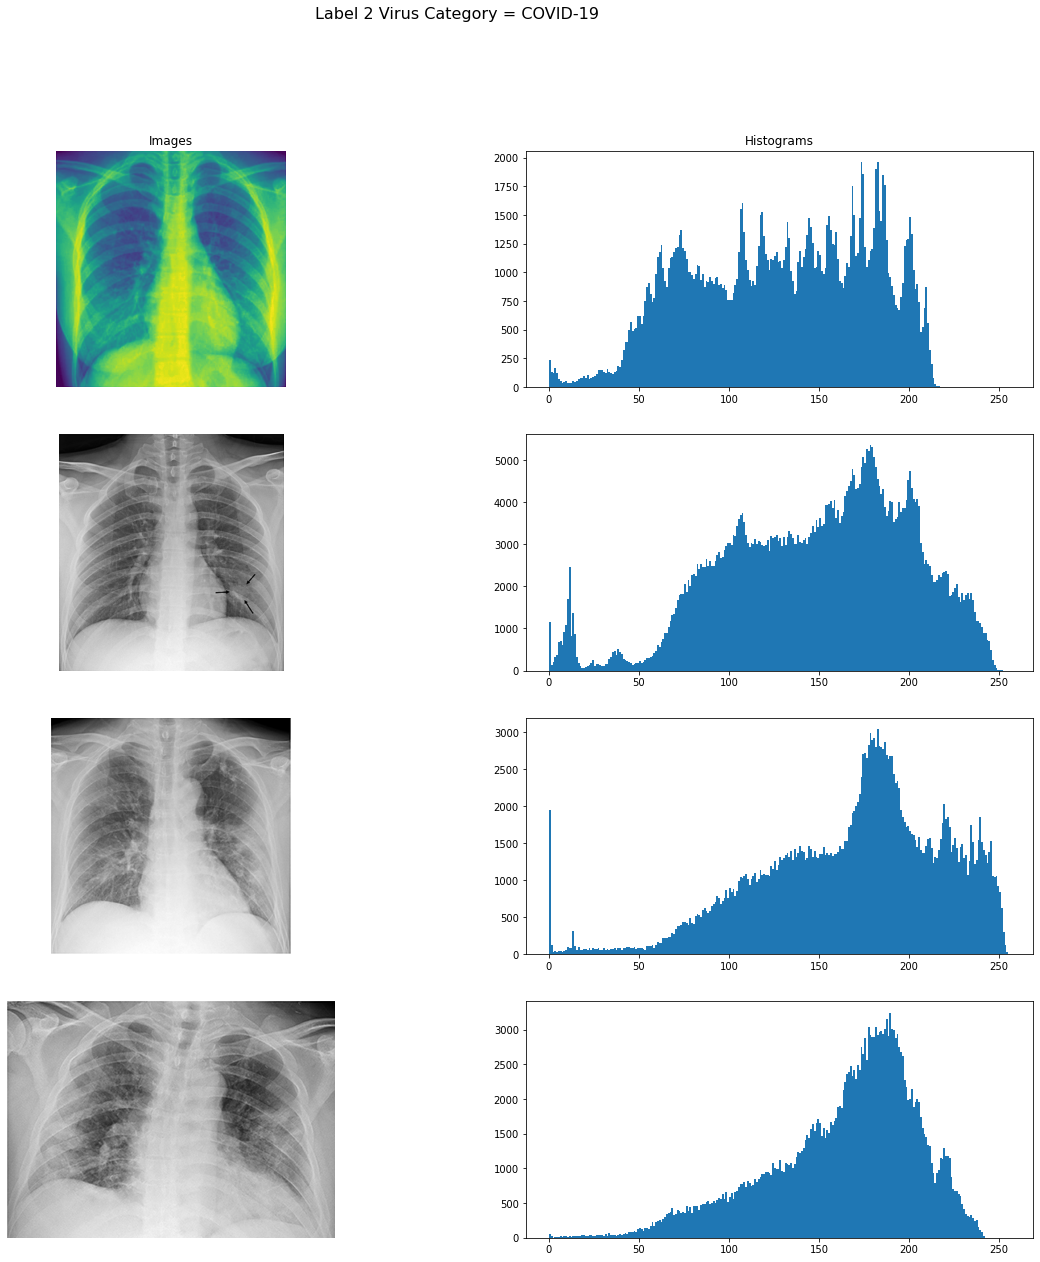

In [49]:
# Plot black/white image histograms of "Label_2_Virus_category" type "COVID-19" patients
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

covid19_type_file_paths = train_data[train_data['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].values
sample_covid19_file_paths = covid19_type_file_paths[:4]
sample_covid19_file_paths = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_covid19_file_paths))

for row, file_path in enumerate(sample_covid19_file_paths):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label 2 Virus Category = COVID-19', size=16)
plt.show()

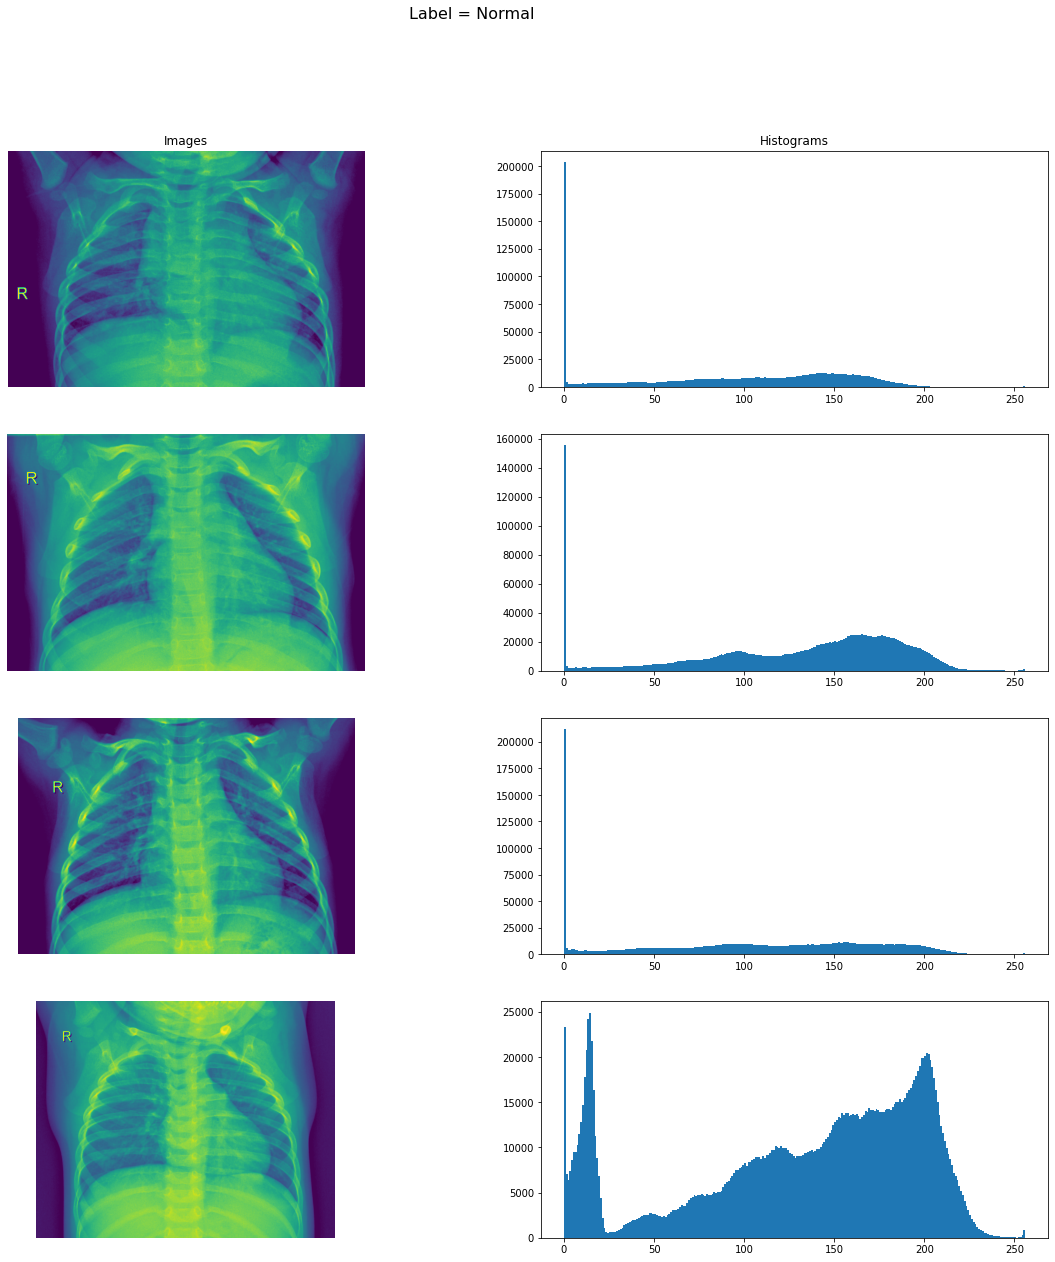

In [50]:
# Plot black/white image histograms of Label type "Normal" patients
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

other_type_file_paths = train_data[train_data['Label'] == 'Normal']['X_ray_image_name'].values
sample_other_file_paths = other_type_file_paths[:4]
sample_other_file_paths = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_other_file_paths))

for row, file_path in enumerate(sample_other_file_paths):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label = Normal', size=16)
plt.show()

### Inference
- From the sample images, seperated according to Label 2 Virus Category into COVID-19 and Other, we can infer the difference in image histograms
- The sample histograms of images having target as COVID-19 are mostly left-skewed histograms.
- The sample histograms of images which have Label value as Normal are mostly right skewed histograms (with exception of image 4).

## Image Augumentation
Deep networks need large amount of training data to achieve good performance. To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc

- We will be using keras ImageDataGenerator's inbuilt image augumentation functionality for the process of image augumentation.

In [59]:
# Sort out the file names to be worked on
# Generate the final train data from original train data with conditions refered from EDA inference
# We are classifying 'normal' and '(Pnemonia & COVID-19)'
final_train_data = train_data[(train_data['Label'] == 'Normal') |
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]


# Create a target attribute where value = positive if 'Pnemonia + COVID-19' or value = negative if 'Normal'
final_train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

final_train_data = shuffle(final_train_data, random_state=1)

final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

print(f"Final train data shape : {final_train_data.shape}")
final_train_data.sample(10)


Final train data shape : (1000, 7)


Unnamed: 0           X_ray_image_name   Label Dataset_type  \
241          241          IM-0423-0001.jpeg  Normal        TRAIN   
1032        1032  NORMAL2-IM-1002-0001.jpeg  Normal        TRAIN   
1154        1154  NORMAL2-IM-1162-0001.jpeg  Normal        TRAIN   
227          227          IM-0435-0001.jpeg  Normal        TRAIN   
1148        1148  NORMAL2-IM-1170-0001.jpeg  Normal        TRAIN   
0              0          IM-0128-0001.jpeg  Normal        TRAIN   
575          575          IM-0706-0001.jpeg  Normal        TRAIN   
529          529          IM-0683-0001.jpeg  Normal        TRAIN   
824          824  NORMAL2-IM-0655-0001.jpeg  Normal        TRAIN   
120          120          IM-0313-0001.jpeg  Normal        TRAIN   

     Label_2_Virus_category Label_1_Virus_category    target  
241                     NaN                    NaN  negative  
1032                    NaN                    NaN  negative  
1154                    NaN                    NaN  negative  
227                     NaN                    NaN  negative  
1148                    NaN                    NaN  negative  
0                       NaN                    NaN  negative  
575                     NaN                    NaN  negative  
529                     NaN                    NaN  negative  
824                     NaN                    NaN  negative  
120                     NaN                    NaN  negative

In [60]:
# We perform Image Agumentation

# train_image_generator
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

# test_image_generator
test_image_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=TEST_FOLDER,
    x_col='X_ray_image_name',
    target_size=(224, 224),
    shuffle=False,
    batch_size=16,
    class_mode=None
)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


## Base CNN model accuracy calculation
- The given 69 images divided into 4 classes will be trained on a simple 3 convolution layers CNN

In [53]:
def scheduler(epoch):
    if epoch < 5:
        return 0.0001
    else:
        print(f"Learning rate reduced to {0.0001 * np.exp(0.5 * (5 - epoch))}")
        return 0.0001 * np.exp(0.5 * (5 - epoch))


custom_callback = LearningRateScheduler(scheduler)

# Metrics
METRICS = [
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
]

In [ ]:
# creating the model
model = Sequential([
    Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss=binary_crossentropy,
             metrics=METRICS)

history = model.fit_generator(train_generator,
                   validation_data=validation_generator,
                   epochs=20,
                   callbacks=[custom_callback])


In [ ]:
model.save('covid19_xray_base_cnn_model.h5')
ACCURACY_LIST.append(['Base CNN Model', history])
#  accuracy: 0.9650
#  val_accuracy: 0.9425


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('Base CNN model', size=16)
plt.show()


### Inference from base CNN model accuracy and AUC
- Base CNN model
    * Train data accuracy = 95.4 %
    * Validation data accuracy = 97 %
- Possible reasons for stale accuracy on 20 epochs

    - Highly imbalance target variables
        * COVID-19 target value = positive rows have count as 58
        * Normal target value = negative rows have count as 1342
        * 100 * (1342 / 1400) ~ 95.86 %
        * Even if model classifies all the images as "Normal" label, it would achieve 95.86 % accuracy
        
- Changes to make:
     - A good measure for imbalanced dataset is Area Under the Curve(AUC)
     - The metrics for the model changed to AUC
     - Comparision of models will be done based on AUC score
    

### Base CNN model with lower imbalance in data
- In this subsection, we try to remove 95.86 % imbalance present in the data
- We will remove 4 / 5 th of the Normal labelled images while keeping the count of COVID-19 labelled images same
- 1342 / 5 ~ 269; 269 / (269 + 58) ~ 82.26 %
- To compensate for less number of training images, we increase the number of epochs

In [61]:
balanced_data = train_data[(train_data['Label'] == 'Normal') |
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]

balanced_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in balanced_data['Label']]

balanced_data_subset_normal = balanced_data[balanced_data['target'] == 'negative']
balanced_data_subset_covid = balanced_data[balanced_data['target'] == 'positive']
balanced_data_frac_normal = balanced_data_subset_normal.sample(frac=(1/5))

balanced_data_concat = pd.concat([balanced_data_frac_normal, balanced_data_subset_covid], axis=0)
balanced_data_concat = shuffle(balanced_data_concat, random_state=0)
balanced_data_train = balanced_data_concat[:240]
balanced_data_validation = balanced_data_concat[240:]

print(f"Balanced train data shape {balanced_data_train.shape}")
print(f"Balanced validation data shape {balanced_data_validation.shape}")

Balanced train data shape (240, 7)
Balanced validation data shape (86, 7)


In [62]:

balanced_train_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_train,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

balanced_validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_validation,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 240 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.


In [27]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

balanced_model = Sequential([
    Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

balanced_model.compile(optimizer=Adam(), loss=binary_crossentropy,
             metrics=METRICS)

In [ ]:
balanced_model.summary()

In [ ]:
balanced_history = balanced_model.fit_generator(balanced_train_generator,
                                               epochs=30,
                                               validation_data=balanced_validation_generator,
                                               callbacks=[custom_callback])

In [ ]:
balanced_model.save('covid19_xray_base_cnn_model_balanced.h5')
ACCURACY_LIST.append(['Balanced Base Model', balanced_history])
# accuracy: 0.8458
# val_accuracy: 0.7558

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('Balanced base CNN model', size=16)
plt.show()

### Inferences
- Reducing imbalances results in reduced training images
- Accuracy reduced because of reduced training images
- Validation accuracy still remains stale even on reducing number of "Normal" labelled images
- changes made:
    - A good measure for imbalanced dataset is Area Under the Curve(AUC)
    - The metrics for the model changed to AUC in version 5
    - Comparision of models will be done based on AUC score

## Training ResNet 50 on data

In [56]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

def output_custom_model(prebuilt_model):
    print(f"Processing {prebuilt_model}")
    prebuilt = prebuilt_model(include_top=False,
                            input_shape=(224, 224, 3),
                            weights='imagenet')
    
    # don't train existing weights
    for layer in prebuilt_model.layers:
        layer.trainable = False
        
    output = Flatten()(prebuilt.output)
    output = GlobalMaxPooling2D()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=prebuilt.input, outputs=output)
    model.compile(optimizer='sgd', loss=binary_crossentropy,
              metrics=METRICS)
    return model

In [ ]:
resnet_custom_model = output_custom_model(ResNet50)
resnet_history = resnet_custom_model.fit_generator(train_generator,
                                 epochs=20,
                                 validation_data=validation_generator,
                                 callbacks=[custom_callback])

In [ ]:
resnet_custom_model.save('covid19_xray_resnet_50.h5')  # saving the model
ACCURACY_LIST.append(['ResNet 50', resnet_history])

# accuracy: 0.9690
# val_accuracy: 0.9800

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('ResNet 50 model', size=16)
plt.show()

## Training Xception on data

In [71]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]


xception_custom_model = output_custom_model(Xception)
xception_history = xception_custom_model.fit_generator(train_generator,
                                 epochs=5,
                                 validation_data=validation_generator,
                                 callbacks=[custom_callback])

Processing <function Xception at 0x0000020F52E96318>
Epoch 1/5
125/125 [==============================] - 749s 6s/step - loss: 0.2481 - tp: 3.0000 - fp: 39.0000 - tn: 926.0000 - fn: 32.0000 - accuracy: 0.9290 - precision: 0.0714 - recall: 0.0857 - auc: 0.6505 - val_loss: 0.1788 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 23.0000 - val_accuracy: 0.9425 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8574
Epoch 2/5
125/125 [==============================] - 790s 6s/step - loss: 0.1597 - tp: 0.0000e+00 - fp: 1.0000 - tn: 964.0000 - fn: 35.0000 - accuracy: 0.9640 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7145 - val_loss: 0.1740 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 376.0000 - val_fn: 23.0000 - val_accuracy: 0.9400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8555
Epoch 3/5
125/125 [==============================] - 789s 6s/step - loss: 0.1434 - tp: 1.0000 - fp: 0.0000e+00 - tn: 965.0000 - fn: 34.0000 - 

In [72]:
xception_custom_model.save('covid19_xray_xception_custom_model.h5')
# ACCURACY_LIST.append(['Xception', xception_history])
# accuracy: 0.9640 
# val_accuracy: 0.9425

### Binary Accuracy and AUC score comparision
- As the data is imbalanced, more concentration will be given on AUC score comparision

In [79]:
ACCURACY_LIST = np.array(ACCURACY_LIST)
model_names = ACCURACY_LIST[:, 0]
histories = ACCURACY_LIST[:, 1]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('auc')[-1], histories)), ax=ax[0, 0], palette='Spectral')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_auc')[-1], histories)), ax=ax[0, 1], palette='gist_yarg')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('accuracy')[-1], histories)), ax=ax[1, 0], palette='rocket')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_accuracy')[-1], histories)), ax=ax[1, 1], palette='ocean_r')
ax[0, 0].set_title('Model Training AUC scores')
ax[0, 1].set_title('Model Validation AUC scores')
ax[1, 0].set_title('Model Training Accuracies')
ax[1, 1].set_title('Model Validation Accuracies')
fig.suptitle('Model Comparisions')
plt.show()

IndexError: too many indices for array

### TP, FP, TN, FN model comparisions

In [ ]:
metric_dataframe = pd.DataFrame({
    'Model Names': model_names,
    'True Positives': list(map(lambda x: x.history.get('tp')[-1], histories)),
    'False Positives': list(map(lambda x: x.history.get('fp')[-1], histories)),
    'True Negatives': list(map(lambda x: x.history.get('tn')[-1], histories)),
    'False Negatives': list(map(lambda x: x.history.get('fn')[-1], histories))
})
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x='Model Names', y='True Positives', data=metric_dataframe, ax=ax[0, 0], palette='BrBG')
sns.barplot(x='Model Names', y='False Positives', data=metric_dataframe, ax=ax[0, 1], palette='icefire_r')
sns.barplot(x='Model Names', y='True Negatives', data=metric_dataframe, ax=ax[1, 0], palette='PuBu_r')
sns.barplot(x='Model Names', y='False Negatives', data=metric_dataframe, ax=ax[1, 1], palette='YlOrBr')
ax[0, 0].set_title('True Positives of Models')
ax[0, 1].set_title('False Positives of Models')
ax[1, 0].set_title('True Negatives of Models')
ax[1, 1].set_title('False Negatives of Models')
fig.suptitle('Confusion Matrix comparision of Models', size=16)
plt.show()

## Predicting using the saved model

In [28]:
import cv2

CATRGORIES = ["COVID-19", "Normal"]

def prepare(filepath):
    IMG_SIZE = 224
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE), 3)
    return new_array.reshape(1, 224, 224, 3)


productionModel = tf.keras.models.load_model('covid19_xray_resnet_50.h5')
pred = productionModel.predict([prepare('dataset/test/NORMAL2-IM-0374-0001-0001.jpeg')])
print(CATRGORIES[int(round(pred[0][0]))]) #Normal

pred = productionModel.predict([prepare('dataset/test/person76_virus_138.jpeg')])
print(CATRGORIES[int(round(pred[0][0]))])  #COVID-19

pred = productionModel.predict([prepare('dataset/test/IM-0091-0001.jpeg')])
print(CATRGORIES[int(round(pred[0][0]))]) #Normal

pred = productionModel.predict([prepare('dataset/test/person1668_virus_2882.jpeg')])
print(CATRGORIES[int(round(pred[0][0]))])  #COVID-19

Normal
COVID-19
Normal
COVID-19
